In [2]:
from kaveh.behavioral.oculomotor.session import session
from kaveh.toolbox import find_file
from neo.io import Spike2IO
from matplotlib import pyplot as plt
import numpy as np
import quantities as pq
import csv


In [3]:
def bin_error_dirs(error_dirs):
    '''
    Bin error directions: Bins start from 157.5 and increaments counter-clockwise every 45 degrees => 8 bins, 0 to 7
    '''
    bins = np.arange(-180 + 22.5, 180, 45)
    bin_ind = np.digitize(error_dirs , bins, right=True)
    bin_ind[bin_ind == 8] = 0
    return bin_ind


def get_bin_cs_counts(cs_range, event_times, bin_ind, error_dir_bin_numbers, cs_times):
    '''
    get cs_counts for each bin
    '''
    cs_range = pq.quantity.Quantity(cs_range, 's')
    bin_cs_counts = []

    for ebn in error_dir_bin_numbers:
        bin_times = event_times[bin_ind == ebn]
        cs_count = 0
        if bin_times.size != 0:
            for bt in bin_times:
                cs_count = cs_count + np.count_nonzero(np.where(np.logical_and(cs_times < bt+cs_range, cs_times > bt )))
            cs_count = cs_count*1.0/bin_times.size
            bin_cs_counts.append(cs_count)
        else:
            bin_cs_counts.append(0)
        
    bin_cs_counts = np.array(bin_cs_counts)
#     bin_cs_counts = bin_cs_counts*1.0/np.sum(bin_cs_counts)
    return bin_cs_counts


In [4]:
# These are Buckley files with the following event structure:
# Event 0
# Event 1
# Event 2
# Event 3 : Trial onset
# Event 4 : Primary target presentation in adaptation trials
# Event 5 : Corrective target presentation in adaptation trials
# Event 6 : Divide each trial into its target jumps
# Event 7 : 
buckley_files_correct_events = ['B082107_1340_List.smr', #yes
'B090407_1526_List.smr', # yes
# 'B091208_1545_List.smr', # No done
# 'B091608_1208_List.smr', # No done
'B091707_1414_List.smr', # No done
'B091908_1_1500_List.smr', # No done
'B091908_2_1550_List.smr', # No done
'B093008_1149_List.smr', # No done
'B100308_2_1403_List.smr', # No done
'W091008_1241_List.smr', # No done
'W091208_1337_List.smr', # No done: bimodal cs-on
'W120208_1_1418_List.smr', # No done
'W120508_1_1420_List.smr', # No done
'W120508_2_1628_List.smr'] # No

# f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_25deg/B082107/B082107_1340_List.smr'
# f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_25deg/B110807/B110807_1632_List.smr'

In [5]:
file_to_get_tuning_for = buckley_files_correct_events[0]

In [4]:
bin_cs_counts_for_file = {}
bin_cs_counts_iss_for_file = {}
bin_cs_counts_non_iss_for_file = {}

for bf in buckley_files_correct_events:
    f_name = find_file(bf, '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt')
    f_name_csv = find_file(bf+'.pkl.csv', '../data/david_neurons')
    
    neo_reader = Spike2IO(filename=f_name)
    neo_data = neo_reader.read()
    data_block = neo_data[0]
    seg = data_block.segments[0]
    events = seg.events
    
     # Load voltage
    t_signal = seg.analogsignals[-1].times
    signal_fs = seg.analogsignals[-1].sampling_rate
    

    if t_signal[-1] < 700:
        print(f_name)
        print(f_name_csv)
        # Load cs times from csGUI csv files

        with open(f_name_csv, 'r') as csv_f:
            reader = csv.reader(csv_f)
            csv_content = np.array(list(reader), dtype=np.int64)

        cs_indices = np.squeeze(csv_content[np.where(csv_content[:,1] == 1), 0])
        cs_times = t_signal[cs_indices]

        # Load eye data
        # Load eye data
        HE = seg.analogsignals[0].as_array()
        t_HE = seg.analogsignals[0].times;

        VE = seg.analogsignals[1].as_array()
        t_VE = seg.analogsignals[1].times

        HT = seg.analogsignals[2].as_array()
        t_HT = seg.analogsignals[2].times

        VT = seg.analogsignals[3].as_array()
        t_VT = seg.analogsignals[3].times

        fs = seg.analogsignals[0].sampling_rate
        dt = seg.analogsignals[0].sampling_period



        mysess = session(HT[t_HT <= cs_times[-1]], t_HT[t_HT <= cs_times[-1]], VT[t_VT <= cs_times[-1]], t_VT[t_VT <= cs_times[-1]],
                         HE[t_HE <= cs_times[-1]], t_HE[t_HE <= cs_times[-1]], VE[t_VE <= cs_times[-1]], t_VE[t_VE <= cs_times[-1]], fs, dt)

        mysess._cut_to_min_size()
        mysess._calc_target_velocity()
        mysess._calc_saccade_velocity()

        mysess._detect_target_jumps()
        mysess._detect_saccades()
        print('Number of saccade offset times = {}'.format(mysess.saccade_offset_times.shape))

        # find inra-saccadic target jumps. For each saccade, check if that saccade is accompanied by a simultaneous target jump.
        # If so, it is an intra-saccadic target_jump. 
        # check 25 ms before and after the saccade onset and offset for the target jump onset and offset. if found, the target jump is intra-saccadic

        iss_range = pq.quantity.Quantity(0.025, 's')
        iss_targets = []
        iss_saccades = []
        saccades_with_no_iss_target = []
        for i, (son, soff) in enumerate(zip(mysess.saccade_onset_times, mysess.saccade_offset_times)):
            iss_targets.append(np.where(np.logical_or(np.logical_and(mysess.target_onset_times < son + iss_range, 
                                                                     mysess.target_onset_times > son - iss_range), 
                                                      np.logical_and(mysess.target_offset_times < soff + iss_range, 
                                                                     mysess.target_offset_times > soff - iss_range)))[0])
            if iss_targets[-1].size != 0:
                iss_saccades.append(i)
            if iss_targets[-1].size == 0:
                saccades_with_no_iss_target.append(i)

        iss_targets = np.squeeze(np.array([isst[0] for isst in iss_targets if isst.size != 0]))

        non_iss_target_jumps = np.setdiff1d(np.arange(mysess.target_onset_times.size), iss_targets)

        mysess._calc_error_vectors()

        error_dir_bin_ind = mysess.bin_error_dirs()
        error_mag_bin_ind = mysess.bin_error_mags()

        iss_saccades = np.array(iss_saccades)

        iss_saccades_bin_ind = bin_error_dirs(mysess.error_dir[iss_saccades])
        non_iss_saccades_bin_ind = bin_error_dirs(mysess.error_dir[saccades_with_no_iss_target])

        error_dir_bin_numbers = np.unique(error_dir_bin_ind)
        error_mag_bin_numbers = np.unique(error_mag_bin_ind)

        bin_cs_counts_for_file[bf] = get_bin_cs_counts(0.200, mysess.saccade_offset_times, error_dir_bin_ind, error_dir_bin_numbers, cs_times)
        bin_cs_counts_iss_for_file[bf] = get_bin_cs_counts(0.200, mysess.saccade_offset_times[iss_saccades], iss_saccades_bin_ind, error_dir_bin_numbers, cs_times)
        bin_cs_counts_non_iss_for_file[bf] = get_bin_cs_counts(0.200, mysess.saccade_offset_times[saccades_with_no_iss_target], non_iss_saccades_bin_ind, error_dir_bin_numbers, cs_times)

        print(bin_cs_counts_for_file[bf])
        print(bin_cs_counts_iss_for_file[bf])
        print(bin_cs_counts_non_iss_for_file[bf])

/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_12deg/B091908_1/B091908_1_1500_List.smr
../data/david_neurons/B091908_1/B091908_1_1500_List.smr.pkl.csv


/usr/local/lib/python2.7/dist-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Number of saccade offset times = (473,)
[0.04255319 0.11290323 0.20408163 0.25581395 0.19047619 0.24324324
 0.09090909 0.03921569]
[0.05555556 0.05405405 0.16       0.29032258 0.15625    0.14814815
 0.04166667 0.        ]
[0.03448276 0.13793103 0.25       0.16666667 0.3        0.5
 0.22222222 0.07692308]
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_12deg/B091908_2/B091908_2_1550_List.smr
../data/david_neurons/B091908_2/B091908_2_1550_List.smr.pkl.csv
Number of saccade offset times = (804,)
[0.1547619  0.13084112 0.17004049 0.17       0.2244898  0.125
 0.05714286 0.09302326]
[0.14634146 0.04081633 0.15789474 0.11111111 0.19444444 0.11538462
 0.07692308 0.08333333]
[0.1627907  0.15757576 0.1722488  0.203125   0.30769231 0.16666667
 0.         0.14285714]
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_12deg/B093008/B093008_1149_List.smr
../data/david_neurons/B093008/B093008_1149_List.smr.pkl.csv
Number of saccade offset times = (467,)
[0.11940299 

In [9]:
bins = np.arange(-180 + 22.5, 180, 45)
print(bins)

[-157.5 -112.5  -67.5  -22.5   22.5   67.5  112.5  157.5]


In [27]:
tunings_all = []
for val in bin_cs_counts_for_file.values():
    print(val)
    print(np.argmax(val))
    zero_idx = np.argmax(val)
    tunings_all.append(np.roll(val, 3-zero_idx , axis=0))
    
tunings_iss = []
for val in bin_cs_counts_iss_for_file.values():
    print(val)
    print(np.argmax(val))
    zero_idx = np.argmax(val)
    tunings_iss.append(np.roll(val, 3-zero_idx , axis=0))
    
tunings_non_iss = []
for val in bin_cs_counts_non_iss_for_file.values():
    print(val)
    print(np.argmax(val))
    zero_idx = np.argmax(val)
    tunings_non_iss.append(np.roll(val, 3-zero_idx , axis=0))
#     stim_tunings.append(np.roll(csv_content, 3-zero_idx , axis=1)[3,:])
    

[0.11940299 0.05263158 0.1        0.15151515 0.22580645 0.41666667
 0.25       0.12264151]
5
[0.09401709 0.14285714 0.1        0.15625    0.1        0.225
 0.18681319 0.13095238]
5
[0.33962264 0.2        0.05       0.07692308 0.03658537 0.01449275
 0.13043478 0.19047619]
0
[0.04545455 0.         0.01315789 0.02702703 0.         0.04424779
 0.02531646 0.04878049]
7
[0.1547619  0.13084112 0.17004049 0.17       0.2244898  0.125
 0.05714286 0.09302326]
4
[0.04545455 0.07526882 0.18932039 0.21052632 0.17647059 0.0952381
 0.10204082 0.07692308]
3
[0.04255319 0.11290323 0.20408163 0.25581395 0.19047619 0.24324324
 0.09090909 0.03921569]
3
[0.12987013 0.05263158 0.12068966 0.19354839 0.31884058 0.3902439
 0.32727273 0.15714286]
5
[0.07142857 0.0862069  0.12765957 0.13953488 0.14516129 0.08510638
 0.16666667 0.06      ]
6
[0.09677419 0.05128205 0.08       0.16129032 0.22580645 0.42857143
 0.43478261 0.10344828]
6
[0.10416667 0.25       0.03703704 0.13793103 0.08823529 0.22580645
 0.23333333 0.4

In [29]:
tunings_all = np.array(tunings_all)
print(tunings_all.shape)

tunings_iss = np.array(tunings_iss)
print(tunings_iss.shape)

tunings_non_iss = np.array(tunings_non_iss)
print(tunings_non_iss.shape)

(9, 8)
(9, 8)
(9, 8)


In [46]:
mean_non_iss = np.mean(tunings_non_iss, axis = 0)
sd_non_iss = np.std(tunings_non_iss, axis = 0)/np.sqrt(tunings_non_iss.shape[0]-1)

mean_iss = np.mean(tunings_iss, axis = 0)
sd_iss = np.std(tunings_iss, axis = 0)/np.sqrt(tunings_iss.shape[0]-1)


In [53]:
%matplotlib notebook


<IPython.core.display.Javascript object>


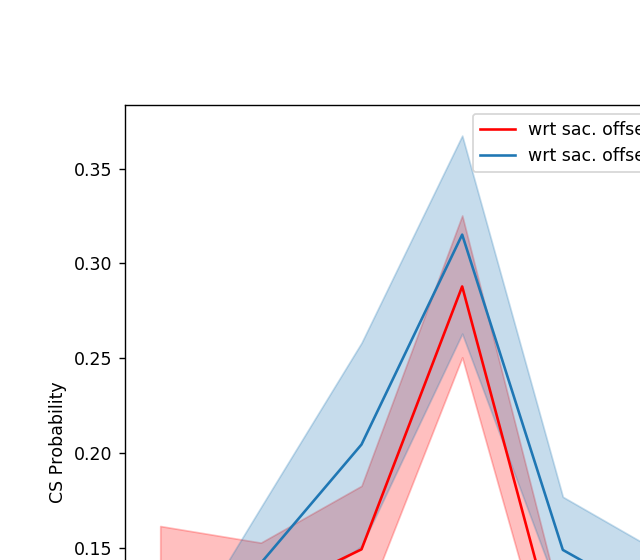

In [58]:
x = [-135, -90, -45, 0, 45, 90, 135, 180]
plt.figure(figsize=(8,7))
l = plt.plot(x, mean_non_iss, 'r')
plt.fill_between(x, mean_non_iss - sd_non_iss, mean_non_iss + sd_non_iss, color=l[0].get_color(), alpha=0.25)

l = plt.plot(x, mean_iss)
plt.fill_between(x, mean_iss - sd_iss, mean_iss + sd_iss, color=l[0].get_color(), alpha=0.25)
plt.xticks(x,x)

plt.xlabel('Degrees from CS-ON')
plt.ylabel('CS Probability')
plt.legend(['wrt sac. offset w/o intra-sac. target jump','wrt sac. offset w/ intra-sac. target jump'])

In [59]:
plt.savefig('../data/plots/tuning_with_respect_to_sac_endpoint.png')

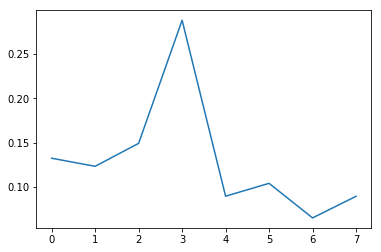

In [39]:
plt.figure()
plt.plot(np.mean(tunings_non_iss, axis = 0))

In [22]:
print(val)
print(np.roll(val, 2, axis=0))

[0.11940299 0.05263158 0.1        0.15151515 0.22580645 0.41666667
 0.25       0.12264151]
[0.25       0.12264151 0.11940299 0.05263158 0.1        0.15151515
 0.22580645 0.41666667]


In [6]:
count = 0
_sum = 0
for key in bin_cs_counts_for_file:
    count += 1
    _sum += bin_cs_counts_for_file[key]

array([0.11584062, 0.0948156 , 0.11943885, 0.15345987, 0.1575367 ,
       0.18213765, 0.14851073, 0.10212838])